<a href="https://colab.research.google.com/github/krushnapavan9/GCN-FMA/blob/main/Graph_convolution_network_FMA_fullv1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#importing dependencies
%%capture
!pip install spektral
import numpy as np
import os
import networkx as nx
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.metrics import classification_report

from spektral.layers import GCNConv

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
import tensorflow as tf
from tensorflow.keras.regularizers import l2

from collections import Counter
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import networkx as nx

In [4]:
import pydot
import requests
import numpy as np
import pandas as pd
import ast
from pandas.api.types import CategoricalDtype

def load(filepath):
  if 'features' in filepath:
    return pd.read_csv(filepath, index_col=0, header=[0, 1, 2])
  if 'tracks' in filepath:
    tracks = pd.read_csv('/content/drive/MyDrive/CS685 data mining/Dataset/fma_metadata/tracks.csv', index_col=0, header=[0, 1])

    COLUMNS = [('track', 'tags'), ('album', 'tags'), ('artist', 'tags'),('track', 'genres'), ('track', 'genres_all')]
    for column in COLUMNS:
        tracks[column] = tracks[column].map(ast.literal_eval)

    COLUMNS = [('track', 'date_created'), ('track', 'date_recorded'),
                ('album', 'date_created'), ('album', 'date_released'),
                ('artist', 'date_created'), ('artist', 'active_year_begin'),
                ('artist', 'active_year_end')]
    for column in COLUMNS:
        tracks[column] = pd.to_datetime(tracks[column])

    SUBSETS = ('small', 'medium', 'large')
    cat_type = CategoricalDtype(categories=SUBSETS, ordered=True)
    try:
        tracks['set', 'subset'] = tracks['set', 'subset'].astype(cat_type)
    except ValueError:
        # the categories and ordered arguments were removed in pandas 0.25
        tracks['set', 'subset'] = tracks['set', 'subset'].astype(pd.CategoricalDtype(categories=SUBSETS, ordered=True))

    COLUMNS = [('track', 'genre_top'), ('track', 'license'),
                ('album', 'type'), ('album', 'information'),
                ('artist', 'bio')]
    for column in COLUMNS:
        tracks[column] = tracks[column].astype('category')

    return tracks
  
def subset_data(features,tracks,subset='small'):
  bool_subset = tracks['set', 'subset'] <= subset
  features = features.loc[bool_subset, :]
  tracks = tracks.loc[bool_subset, :]
  # tracks = tracks.loc[bool_subset, ('track', 'genre_top')]
  return features,tracks

In [5]:
data_dir_path = '/content/drive/MyDrive/CS685 data mining/Dataset/fma_metadata/'
features_data = load(data_dir_path+'features.csv')
tracks_data = load(data_dir_path+'tracks.csv')
print('features_data\n',features_data.head(),features_data.shape)
print('tracks_data\n',tracks_data.head(),tracks_data.shape)
print('features_data first column',features_data.head().iloc[:,0])


features_data
 feature    chroma_cens                      ...       zcr                    
statistics    kurtosis                      ...       min      skew       std
number              01        02        03  ...        01        01        01
track_id                                    ...                              
2             7.180653  5.230309  0.249321  ...  0.000000  2.089872  0.061448
3             1.888963  0.760539  0.345297  ...  0.000000  1.716724  0.069330
5             0.527563 -0.077654 -0.279610  ...  0.000000  2.193303  0.044861
10            3.702245 -0.291193  2.196742  ...  0.000000  3.542325  0.040800
20           -0.193837 -0.198527  0.201546  ...  0.000977  3.189831  0.030993

[5 rows x 518 columns] (106574, 518)
tracks_data
             album                      ... track                 
         comments        date_created  ...  tags            title
track_id                               ...                       
2               0 2008-11-26 01:44

In [6]:
features_subset,tracks_subset = subset_data(features_data,tracks_data,subset='small')
np.testing.assert_array_equal(features_subset.index, tracks_subset.index)
X  = np.array(features_subset.values)
Y = np.array(tracks_subset.loc[:,('track', 'genre_top')].values)

In [7]:
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(X)
from sklearn.decomposition import KernelPCA
kpca=KernelPCA(n_components=187)
X=kpca.fit_transform(X)

In [8]:
from scipy import spatial

def knn(X,from_inds ,to_inds):
  edges = []
  K = 100
  for a in from_inds:
    all_similarity = []
    for b in to_inds:
      # print(X.loc[a].shape,type(X.loc[a].values))
      # return
      all_similarity.append((b,1-spatial.distance.cosine(X[a,:],X[b,:])))
    all_similarity.sort(key = lambda x: x[1],reverse = True)
    for v2,_ in all_similarity[:K]:
      edges.append((a,v2))
  return edges


def construct_graph(X,Y):
  G = nx.Graph()
  genre_ind = dict()
  
  for i,genre in enumerate(Y):
    genre_ind.setdefault(genre,[]).append(i)
  
  for ind in range(X.shape[0]):
    G.add_node(ind)
    
  sorted_genre = sorted(genre_ind.keys())
  for i in range(len(sorted_genre)):
    for j in range(i+1,len(sorted_genre)):
      print(sorted_genre[i],sorted_genre[j])
      edges = knn(X,genre_ind[sorted_genre[i]],genre_ind[sorted_genre[j]])
      for v1,v2 in edges:
        G.add_edge(v1,v2)
  
  for genre, genre_ind in genre_ind.items():
    for ind1 in genre_ind:
      for ind2 in genre_ind:
        if ind1!=ind2:
          G.add_edge(ind1,ind2)

  
  return G
  

In [9]:
%%time
G = construct_graph(X,Y)

Electronic Experimental
Electronic Folk
Electronic Hip-Hop
Electronic Instrumental
Electronic International
Electronic Pop
Electronic Rock
Experimental Hip-Hop
Experimental Instrumental
Experimental International
Experimental Pop
Experimental Rock
Folk Hip-Hop
Folk Instrumental
Folk International
Folk Pop
Folk Rock
Hip-Hop Instrumental
Hip-Hop International
Hip-Hop Pop
Hip-Hop Rock
Instrumental International
Instrumental Pop
Instrumental Rock
International Pop
International Rock
Pop Rock
CPU times: user 17min 40s, sys: 2.41 s, total: 17min 42s
Wall time: 17min 43s


In [10]:
G_copy = G.copy()

In [11]:
from sklearn.model_selection import train_test_split
from collections import Counter
import random

def split_index(X,Y,train_size=0.05,test_size = 0.7,valid_size = 0.25):
  genre_ind = dict()
  for i,genre in enumerate(Y):
    genre_ind.setdefault(genre,[]).append(i)
  train = []
  valid = []
  test = []
  for gen,ind in genre_ind.items():
    random.shuffle(ind)
    train_temp = ind[:int(len(ind)*train_size)]
    val_temp =  ind[int(len(ind)*train_size):int(len(ind)*(train_size+valid_size))]
    test_temp = ind[int(len(ind)*(train_size+valid_size)):]
    
    train += train_temp
    valid += val_temp
    test += test_temp
  train_split = np.zeros(X.shape[0], dtype=bool)
  test_split = np.zeros(X.shape[0], dtype=bool)
  val_split = np.zeros(X.shape[0], dtype=bool)
  print("Training Data Distribution: \n{}".format(Counter([Y[i] for i in train])))
  print("Validation Data Distribution: \n{}".format(Counter([Y[i] for i in valid])))
  print("test Data Distribution: \n{}".format(Counter([Y[i] for i in test])))
  for i in train:
    train_split[i] = True
  for i in valid:
    val_split[i] = True
  for i in test:
    test_split[i] = True
  return train_split,val_split,test_split

In [12]:
train_mask,val_mask,test_mask= split_index(X,Y)

Training Data Distribution: 
Counter({'Hip-Hop': 50, 'Pop': 50, 'Folk': 50, 'Experimental': 50, 'Rock': 50, 'International': 50, 'Electronic': 50, 'Instrumental': 50})
Validation Data Distribution: 
Counter({'Hip-Hop': 250, 'Pop': 250, 'Folk': 250, 'Experimental': 250, 'Rock': 250, 'International': 250, 'Electronic': 250, 'Instrumental': 250})
test Data Distribution: 
Counter({'Hip-Hop': 700, 'Pop': 700, 'Folk': 700, 'Experimental': 700, 'Rock': 700, 'International': 700, 'Electronic': 700, 'Instrumental': 700})


In [13]:
A = nx.adjacency_matrix(G)

In [14]:
print('Graph info: ', nx.info(G))

Graph info:  Name: 
Type: Graph
Number of nodes: 8000
Number of edges: 6796000
Average degree: 1699.0000


In [15]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

def encode_label(labels):
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(labels)
    labels = to_categorical(labels)
    return labels, label_encoder.classes_

In [16]:
labels_encoded, classes = encode_label(Y)

In [17]:
N = X.shape[0] #the number of nodes
F = X.shape[1] #the size of node features
num_classes = 8

In [23]:
# Parameters
channels = 16           # Number of channels in the first layer
dropout = 0.5           # Dropout rate for the features
l2_reg = 5e-4           # L2 regularization rate
learning_rate = 1e-2    # Learning rate
epochs = 25          # Number of training epochs
es_patience = 10        # Patience for early stopping

# Preprocessing operations
A = GCNConv.preprocess(A).astype('f4')

# Model definition
X_in = Input(shape=(F, ))
fltr_in = Input((N, ), sparse=True)

dropout_1 = Dropout(dropout)(X_in)
graph_conv_1 = GCNConv(channels,
                         activation='relu',
                         kernel_regularizer=l2(l2_reg),
                         use_bias=False)([dropout_1, fltr_in])

dropout_2 = Dropout(dropout)(graph_conv_1)
graph_conv_2 = GCNConv(num_classes,
                         activation='softmax',
                         use_bias=False)([dropout_2, fltr_in])

# Build model
model = Model(inputs=[X_in, fltr_in], outputs=graph_conv_2)
optimizer = Adam(lr=learning_rate)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              weighted_metrics=['acc'])
model.summary()

tbCallBack_GCN = tf.keras.callbacks.TensorBoard(
    log_dir='./Tensorboard_GCN_cora',
)
callback_GCN = [tbCallBack_GCN]

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 187)]        0                                            
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 187)          0           input_3[0][0]                    
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 8000)]       0                                            
__________________________________________________________________________________________________
gcn_conv_2 (GCNConv)            (None, 16)           2992        dropout_2[0][0]                  
                                                                 input_4[0][0]         

In [24]:
#Train model
%%time
validation_data = ([X, A], labels_encoded, val_mask)
model.fit([X, A],
          labels_encoded,
          sample_weight=train_mask,
          epochs=epochs,
          batch_size=N,
          validation_data=validation_data,
          shuffle=False,
          callbacks=[
              EarlyStopping(patience=es_patience,  restore_best_weights=True),
              tbCallBack_GCN
          ])


Epoch 1/25
1/1 [==============================] - 2s 2s/step - loss: 0.1562 - acc: 0.0950 - val_loss: 0.5827 - val_acc: 0.0925
Epoch 2/25
1/1 [==============================] - 0s 495ms/step - loss: 0.1408 - acc: 0.1300 - val_loss: 0.5476 - val_acc: 0.1210
Epoch 3/25
1/1 [==============================] - 0s 474ms/step - loss: 0.1315 - acc: 0.1425 - val_loss: 0.5174 - val_acc: 0.1720
Epoch 4/25
1/1 [==============================] - 0s 482ms/step - loss: 0.1248 - acc: 0.1550 - val_loss: 0.4920 - val_acc: 0.2520
Epoch 5/25
1/1 [==============================] - 0s 485ms/step - loss: 0.1159 - acc: 0.2125 - val_loss: 0.4705 - val_acc: 0.3155
Epoch 6/25
1/1 [==============================] - 0s 480ms/step - loss: 0.1054 - acc: 0.2775 - val_loss: 0.4521 - val_acc: 0.3740
Epoch 7/25
1/1 [==============================] - 0s 482ms/step - loss: 0.1038 - acc: 0.2775 - val_loss: 0.4361 - val_acc: 0.4285
Epoch 8/25
1/1 [==============================] - 0s 487ms/step - loss: 0.0982 - acc: 0.3275 

In [20]:
# Evaluate model
X_te = X[test_mask]
A_te = A[test_mask,:][:,test_mask]
y_te = labels_encoded[test_mask]

y_pred = model.predict([X_te, A_te], batch_size=N)
report = classification_report(np.argmax(y_te,axis=1), np.argmax(y_pred,axis=1), target_names=classes)
print('GCN Classification Report: \n {}'.format(report))

GCN Classification Report: 
                precision    recall  f1-score   support

   Electronic       1.00      1.00      1.00       700
 Experimental       1.00      1.00      1.00       700
         Folk       0.97      1.00      0.99       700
      Hip-Hop       1.00      1.00      1.00       700
 Instrumental       1.00      1.00      1.00       700
International       0.99      1.00      1.00       700
          Pop       1.00      0.96      0.98       700
         Rock       1.00      1.00      1.00       700

     accuracy                           0.99      5600
    macro avg       0.99      0.99      0.99      5600
 weighted avg       0.99      0.99      0.99      5600



In [21]:
np.argmax(y_pred,axis=1)[:200]

array([3, 3, 6, 2, 1, 7, 2, 2, 2, 2, 2, 2, 2, 2, 2, 7, 7, 1, 7, 2, 2, 2,
       1, 2, 2, 5, 5, 3, 3, 3, 5, 5, 5, 2, 2, 7, 2, 6, 6, 5, 2, 1, 7, 1,
       1, 7, 7, 1, 5, 1, 7, 7, 2, 2, 2, 1, 1, 7, 1, 1, 0, 6, 6, 6, 6, 1,
       5, 5, 5, 5, 5, 5, 5, 5, 2, 2, 7, 7, 1, 7, 7, 2, 2, 2, 7, 1, 2, 2,
       2, 2, 2, 2, 2, 7, 6, 2, 2, 6, 0, 7, 2, 2, 7, 7, 7, 7, 7, 7, 7, 7,
       5, 5, 5, 2, 7, 7, 2, 2, 2, 2, 2, 2, 2, 2, 7, 2, 2, 2, 2, 2, 2, 2,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 5,
       5, 5, 5, 5, 2, 5, 5, 5, 5, 0, 0, 0, 3, 3, 3, 3, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 5, 5, 7, 2, 2, 2, 6, 3, 2, 2, 1, 2, 2, 5, 5, 5,
       5, 5])

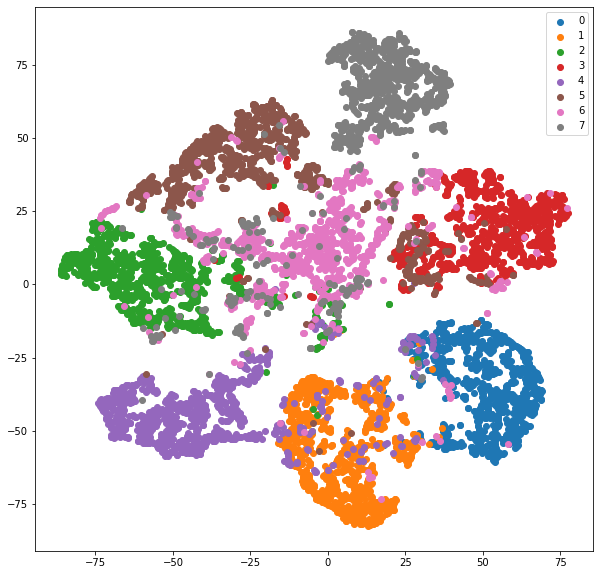

In [22]:
#Get the hidden layer representation after the first GCN layer
layer_outputs = [layer.output for layer in model.layers]
activation_model = Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict([X,A],batch_size=N)

#Get t-SNE Representation
x_tsne = TSNE(n_components=2).fit_transform(activations[3]) 

def plot_tSNE(labels_encoded,x_tsne):
    color_map = np.argmax(labels_encoded, axis=1)
    plt.figure(figsize=(10,10))
    for cl in range(num_classes):
        indices = np.where(color_map==cl)
        indices = indices[0]
        plt.scatter(x_tsne[indices,0], x_tsne[indices, 1], label=cl)
    plt.legend()
    plt.show()
    
plot_tSNE(labels_encoded,x_tsne)

In [33]:
X.shape

(8000, 187)

In [28]:
Y,Y.shape

(array(['Hip-Hop', 'Hip-Hop', 'Pop', ..., 'Pop', 'Pop', 'Hip-Hop'],
       dtype=object), (8000,))

In [41]:
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition, sklearn.svm

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)
# Standardize features by removing the mean and scaling to unit variance.
scaler = sklearn.preprocessing.StandardScaler(copy=False)
scaler.fit_transform(X_train)
scaler.transform(X_test)

# Support vector classification.
clf = sklearn.svm.SVC(probability=True)
clf.fit(X_train, y_train)
score = clf.predict_proba(X_test)
# print('Accuracy: {:.2%}'.format(score))


TypeError: ignored

In [46]:
y_pred = clf.predict(X_test)

In [48]:
print(classification_report(y_test, y_pred, target_names=classes))

               precision    recall  f1-score   support

   Electronic       0.55      0.57      0.56       322
 Experimental       0.43      0.57      0.49       333
         Folk       0.67      0.65      0.66       305
      Hip-Hop       0.65      0.59      0.62       354
 Instrumental       0.58      0.58      0.58       311
International       0.67      0.59      0.63       344
          Pop       0.42      0.39      0.40       318
         Rock       0.72      0.67      0.69       353

     accuracy                           0.58      2640
    macro avg       0.59      0.58      0.58      2640
 weighted avg       0.59      0.58      0.58      2640



In [36]:
from sklearn.ensemble import RandomForestClassifier
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)
scaler = sklearn.preprocessing.StandardScaler(copy=False)
scaler.fit_transform(X_train)
scaler.transform(X_test)
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)
print('Accuracy: {:.2%}'.format(score))

Accuracy: 42.65%
